# Topic 3: Further Document Classification

## Preliminaries 
Run theis cell.

In [1]:
import sys
sys.path.append(r'\\ad.susx.ac.uk\ITS\TeachingResources\Departments\Informatics\LanguageEngineering\resources')
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
from collections import defaultdict,Counter
from itertools import zip_longest
from IPython.display import display
from random import seed
get_ipython().magic('matplotlib inline')
import random
import math
import matplotlib.pylab as pylab
%matplotlib inline
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)
from pylab import rcParams
from operator import itemgetter, attrgetter, methodcaller
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import csv

Also, run the following cell to have access to the functions we defined in the previous topic.

### Overview
This topic builds on the activities of the previous topic on sentiment analysis. You will be focussing on the Amazon review corpus with a view to investigating the following issues.

- What is the impact of varying training data size? To what extent does increasing the quantity of training data improve classifier performance?
- What is the impact of changing domain (i.e. book, dvd, electronics, kitchen). In particular, what happens if you train a classifier with reviews in one domain (or product category) and test the classifier on reviews from a different domain? Does performance degrade, and if so, by how much? Are some pairs of product categories more similar than others?
- What is the impact on classifier accuracy of various feature extraction methods?

By this stage, you should be very comfortable with Python's [list comprehensions](http://docs.python.org/tutorial/datastructures.html#list-comprehensions) and [slice](http://bergbom.blogspot.co.uk/2011/04/python-slice-notation.html) notation.

You will need to run the next cell so that you can use the `split_data` and `format_data` functions  covered in the previous topic.

## Investigating the impact of the quantity of training data
We will begin by exploring the impact on classification accuracy of using different quantities of training data.

We have assembled code from the notebook for Topic 2 in a module called classification_utils.  In the next cell, we load this module.

We now measure the performance of both the word list classifier (the version that uses the 100 most frequent words in each category) and Naïve Bayes classifiers on all of the dvd reviews in the extended dvd review corpus, with 70% of the corpus being used for training and the remainder for testing.

### Exercise
Run this cell several times and observe the output.

Sussex NLTK root directory is \\ad.susx.ac.uk\ITS\TeachingResources\Departments\Informatics\LanguageEngineering\resources
The accuracy of Word List classifer is 0.63
The accuracy of the Naive Bayes classifier is 0.82.


,0,1
0,Word List,0.630000
1,NB,0.816667


(0.5, 1.0)

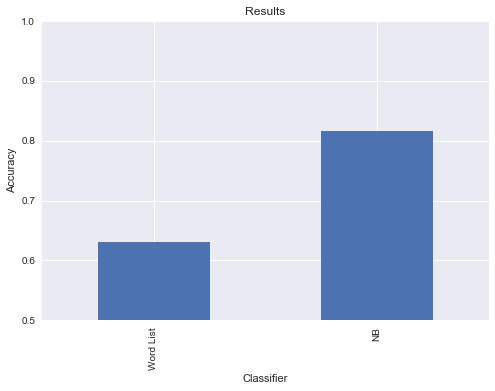

In [4]:
from classification_utils import *

reader = AmazonReviewCorpusReader().category("dvd")
#stopwords = stopwords.words('english')
word_list_size = 100
pos_train,neg_train,pos_test,neg_test = get_train_test_data(reader)
WL_accuracy = run_WL(pos_train,neg_train,pos_test,neg_test,word_list_size)
NB_accuracy = run_NB(pos_train,neg_train,pos_test,neg_test)
print("The accuracy of Word List classifer is {0:.2f}".format(WL_accuracy))
print("The accuracy of the Naive Bayes classifier is {0:.2f}.".format(NB_accuracy))
df = pd.DataFrame([("Word List",WL_accuracy),("NB",NB_accuracy)])
display(df)
ax = df.plot.bar(title="Results",legend=False,x=0)
ax.set_ylabel("Accuracy")
ax.set_xlabel("Classifier")
ax.set_ylim(0.5,1.0)

As you can see, the classifiers have different accuracies on different runs. 

### Exercise
Copy the cell above and move the copy to be positioned below this cell. Then adapt the code so that the accuracy reported for each classifier is the average across multiple runs.

The accuracy of Word List classifer is 0.66
The accuracy of the Naive Bayes classifier is 0.78.


,0,1
0,Word List,0.664000
1,NB,0.784333


(0.5, 1.0)

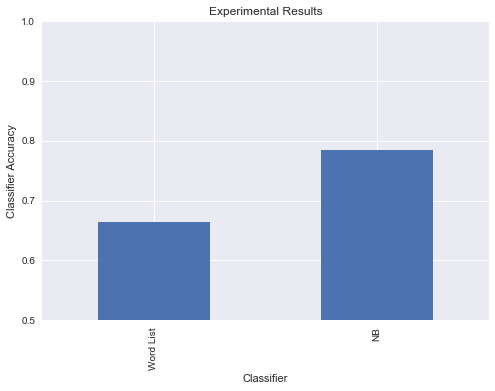

In [6]:
from classification_utils import *

reader = AmazonReviewCorpusReader().category("dvd")
#stopwords = stopwords.words('english')
word_list_size = 200
reps = 5
WL_accuracy_tot = 0
NB_accuracy_tot = 0
for i in range(reps):
    pos_train,neg_train,pos_test,neg_test = get_train_test_data(reader)
    WL_accuracy_tot += run_WL(pos_train,neg_train,pos_test,neg_test,word_list_size)
    NB_accuracy_tot += run_NB(pos_train,neg_train,pos_test,neg_test)
WL_accuracy = WL_accuracy_tot/reps
NB_accuracy = NB_accuracy_tot/reps
print("The accuracy of Word List classifer is {0:.2f}".format(WL_accuracy))
print("The accuracy of the Naive Bayes classifier is {0:.2f}.".format(NB_accuracy))
df = pd.DataFrame([("Word List",WL_accuracy),("NB",NB_accuracy)])
display(df)
ax = df.plot.bar(title="Experimental Results",legend=False,x=0)
ax.set_ylabel("Classifier Accuracy")
ax.set_xlabel("Classifier")
ax.set_ylim(0.5,1.0)

In [1]:
# %load solutions/average_performance
from classification_utils import * 

dvd_reader = AmazonReviewCorpusReader().category("dvd")
word_list_size = 100
repetitions = 5 # accuracy figures are averaged over this many repetitions
WL_accuracy_tot = 0
NB_accuracy_tot = 0
for i in range(repetitions): # for each sample_size we will find average accuracy over several repetitions
    pos_train,neg_train,pos_test,neg_test = get_train_test_data(dvd_reader)
    WL_accuracy_tot += run_WL(pos_train,neg_train,pos_test,neg_test,word_list_size)
    NB_accuracy_tot += run_NB(pos_train,neg_train,pos_test,neg_test)
WL_accuracy = WL_accuracy_tot/repetitions
NB_accuracy = NB_accuracy_tot/repetitions
df = pd.DataFrame([("Word List",WL_accuracy),("NB",NB_accuracy)])
display(df)
ax = df.plot.bar(title="Experimental Results",legend=False,x=0)
ax.set_ylabel("Classifier Accuracy")
ax.set_xlabel("Classifier")
ax.set_ylim(0.5,1.0)


ModuleNotFoundError: No module named 'classification_utils'

### Exercise

The next step involves measuring the performance of both the word list and Naïve Bayes classifiers on a range of subsets of the dvd reviews in the extended dvd review corpus.

- The full data set has 1000 positive and 1000 negative reviews. 
- You should continue to use 30% of the data for testing, so this means that we have up to 700 positive and 700 negative reviews to sample from.
- Consider (at least) the following sample sizes: 1, 10, 50, 100, 200, 400, 600 and 700.
- Note that the sample size is not the total number of reviews, but the number of positive reviews (which is also equal to the number of negative reviews).

### Exercise
Copy the code cell that you created for the last exercise, and place the copy below this cell. Then adapt the code to determine the accurracy of each classifier on each subsets.

Use the `sample` function from the random module, which means you should include the line:  
`from random import sample`
- Make sure that you are selecting samples that have an equal number of positive and negative reviews.

Use a Pandas dataframe to display the results in a table.
- The table should have three columns:
 - the first for the sample sizes, 
 - the second for the Word List classifier accuracies, and 
 - the third for the Naïve Bayes classifier accuracies.
- There are examples of this in the model solutions to exercises in Topic 1 that you can adapt.
- You can use `pd.set_option('precision',2)` to limit the reals to have 2 digits after the decimal point.
- Create a dataframe like this:
```
pd.DataFrame(list(zip(<column 1 list>, <column 2 list>, ...)),
                  columns=<a list of the column headings)
```

In [ ]:
from random import sample
from classification_utils import *
from random import randint
reader = AmazonReviewCorpusReader().category("dvd")
#stopwords = stopwords.words('english')
word_list_size = 100
repititions = randint(2, 5)
samples = [1, 10, 50, 100, 200, 400, 600, 700]
WL_tots = []
NB_tots = []
for size in samples:
    WL_tot = 0
    NB_tot = 0
    for i in range(repititions):
        pos_train,neg_train,pos_test,neg_test = get_train_test_data(reader)
        pos_train_sample = sample(pos_train, size)
        neg_train_sample = sample(neg_train, size)
        WL_tot += run_WL(pos_train,neg_train,pos_test,neg_test,word_list_size)
        NB_tot += run_NB(pos_train,neg_train,pos_test,neg_test)
    WL_tots.append(WL_tot/repititions)
    NB_tots.append(NB_tot/repititions)

df = pd.DataFrame(list(zip(samples, WL_tots, NB_tots)), columns = ["Sizes", "WL", "NB"])
display(df)

,Sizes,WL,NB
0,1,0.646111,0.793333
1,10,0.642778,0.803333
2,50,0.616667,0.786111
3,100,0.633889,0.799444
4,200,0.632222,0.810556
5,400,0.643889,0.795556
6,600,0.620556,0.794444
7,700,0.636111,0.783889


In [ ]:
# %load solutions/different_sample_sizes
from classification_utils import *

reader = AmazonReviewCorpusReader().category("dvd")
word_list_size = 100
repetitions = 1
sample_sizes = [1,10,50,100,200,400,600,700]
WL_accuracies = []
NB_accuracies = []

for size in sample_sizes:
    WL_accuracy_tot = 0
    NB_accuracy_tot = 0
    for i in range(repetitions): # for each sample_size we will find average accuracy over several repetitions
        pos_train,neg_train,pos_test,neg_test = get_train_test_data(reader)
        pos_train_sample = sample(pos_train, size) 
        neg_train_sample = sample(neg_train, size) 
        WL_accuracy_tot += run_WL(pos_train_sample,neg_train_sample,pos_test,neg_test,word_list_size)
        NB_accuracy_tot += run_NB(pos_train_sample,neg_train_sample,pos_test,neg_test)
    WL_accuracies.append(WL_accuracy_tot/repetitions)
    NB_accuracies.append(NB_accuracy_tot/repetitions)

pd.set_option('precision',2)
df = pd.DataFrame(list(zip(sample_sizes, WL_accuracies, NB_accuracies)),
                  columns=["Sample size","WL accuracy","NB accuracy"])    
display(df)
ax = df.plot(title="Experimental Results",x=0)
ax.set_ylabel("Classifier Accuracy")
ax.set_ylim(0.4,1.0)


### Exercise

Make a copy of the cell you created for the previous exercise and move it to be positioned below this cell. Using the new cell, repeat the above for each of the product categories.
- The available categories are `'dvd'`, `'book'`, `'kitchen'` and `'electronics'`. 

,Sizes,WL,NB
0,1,0.646667,0.786667
1,10,0.631667,0.771667
2,50,0.616667,0.785000
3,100,0.635000,0.795000
4,200,0.663333,0.801667
5,400,0.673333,0.790000
6,600,0.626667,0.796667
7,700,0.645000,0.776667


,Sizes,WL,NB
0,1,0.646667,0.786667
1,10,0.631667,0.771667
2,50,0.616667,0.785000
3,100,0.635000,0.795000
4,200,0.663333,0.801667
5,400,0.673333,0.790000
6,600,0.626667,0.796667
7,700,0.645000,0.776667


,Sizes,WL,NB
0,1,0.646667,0.786667
1,10,0.631667,0.771667
2,50,0.616667,0.785000
3,100,0.635000,0.795000
4,200,0.663333,0.801667
5,400,0.673333,0.790000
6,600,0.626667,0.796667
7,700,0.645000,0.776667


,Sizes,WL,NB
0,1,0.646667,0.786667
1,10,0.631667,0.771667
2,50,0.616667,0.785000
3,100,0.635000,0.795000
4,200,0.663333,0.801667
5,400,0.673333,0.790000
6,600,0.626667,0.796667
7,700,0.645000,0.776667


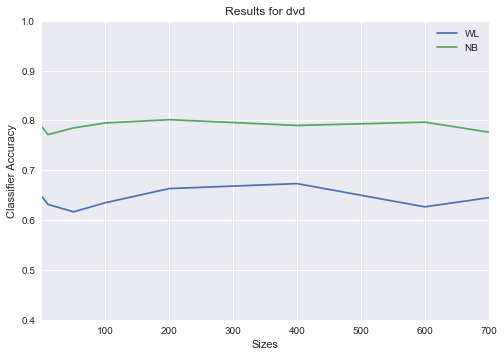

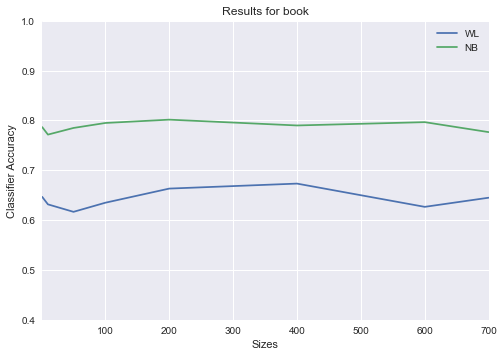

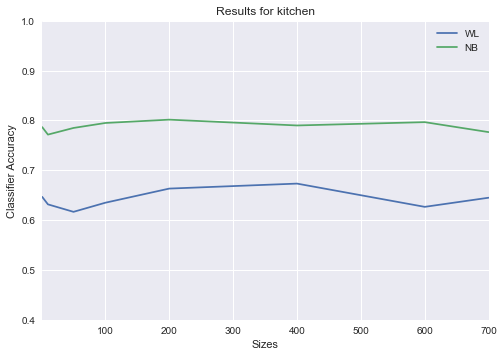

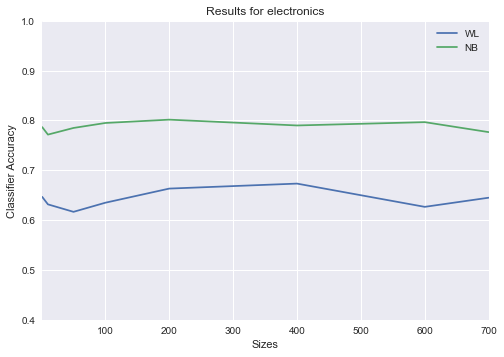

In [7]:
from random import sample
from classification_utils import *
#from random import randint
categories = ["dvd", "book", "kitchen", "electronics"]
#stopwords = stopwords.words('english')
word_list_size = 100
repititions = 1
samples = [1, 10, 50, 100, 200, 400, 600, 700]
WL_tots = []
NB_tots = []
for category in categories:
    reader = AmazonReviewCorpusReader().category(category)
    for size in samples:
        WL_tot = 0
        NB_tot = 0
        for i in range(repititions):
            pos_train,neg_train,pos_test,neg_test = get_train_test_data(reader)
            pos_train_sample = sample(pos_train, size)
            neg_train_sample = sample(neg_train, size)
            WL_tot += run_WL(pos_train,neg_train,pos_test,neg_test,word_list_size)
            NB_tot += run_NB(pos_train,neg_train,pos_test,neg_test)
        WL_tots.append(WL_tot/repititions)
        NB_tots.append(NB_tot/repititions)
    #print(category)
    df = pd.DataFrame(list(zip(samples, WL_tots, NB_tots)), columns = ["Sizes", "WL", "NB"])
    display(df)
    ax = df.plot(title = "Results for {}".format(category),x=0)
    ax.set_ylabel("Classifier Accuracy")
    ax.set_ylim(0.4,1.0)

In [1]:
# %load solutions/different_categories
from classification_utils import *

categories = (["book","dvd","kitchen","electronics"])
for cat in categories:
    reader = AmazonReviewCorpusReader().category(cat)
    word_list_size = 100
    repetitions = 1 # accuracy figures are averaged over this many repetitions
    sample_sizes = [1,10,50,100,200,400,600,700] #sample_size = number of the positive reviews =  number of negative reviews
    WL_accuracies=[]
    NB_accuracies=[]
    for size in sample_sizes:
        WL_accuracy_tot = 0
        NB_accuracy_tot = 0
        for i in range(repetitions): # for each sample_size we will find average accuracy over several repetitions
            pos_train,neg_train,pos_test,neg_test = get_train_test_data(reader)
            pos_train_sample = sample(pos_train, size) 
            neg_train_sample = sample(neg_train, size) 
            WL_accuracy_tot += run_WL(pos_train_sample,neg_train_sample,pos_test,neg_test,word_list_size)
            NB_accuracy_tot += run_NB(pos_train_sample,neg_train_sample,pos_test,neg_test)
        WL_accuracies.append(WL_accuracy_tot/repetitions)
        NB_accuracies.append(NB_accuracy_tot/repetitions)
    pd.set_option('precision', 2)
    df = pd.DataFrame(list(zip(sample_sizes, WL_accuracies, NB_accuracies)),
                      columns=["Sample size","WL accuracy","NB accuracy"])
    ax = df.plot(title="Results for category {}".format(cat),x=0)
    ax.set_ylabel("Classifier Accuracy")
    ax.set_ylim(0.4,1.0)


ModuleNotFoundError: No module named 'classification_utils'

## Cross-domain sentiment analysis
We now consider the extend to which the performance of a Naïve Bayes classifier is degraded due to differences between the data it is trained on and the data that it is tested on. 

For example, suppose we train a classifier on book reviews and then test that classifier on a collection of dvd reviews. Does it perform as well as it would when trained on dvd reviews?

We will refer to the domain or product category that the classifier is trained on as the **source domain** and the domain or product category that the classifier is tested on as the **target domain**. You will be experimenting with different combinations of source and target domains.

There are 4 product categories so there are 16 different ways in which these can be combined to create training and testing datasets.

### Exercise
In the empty cell below, write code that determines the accuracy of the Naïve Bayes classifier for each of these 16 combinations.
- use a pandas dataframe to report the results in a table with three columns:
 - the first column is the source category,
 - the second column is the target category, and
 - the third column is the accuracy for the corresponing source and target categories.
- So each row of the table gives the accuracy for one of the combinations.
 - There should, therefore, be 16 rows.

Ideally, the accuracies that you report should be averaged over multiple runs (as we saw above). However, since there are 16 combinations to consider, in order to avoid overly long running times, you do not need to run the classifier more than once for each combination.

Now that we are just running the Naïve Bayes classifier, it makes sense to format the data before passing it to our `run_NB` function. 

We having included in `classification_util.py` a variant of `get_train_test_data` called `get_formatted_train_test_data` that is defined as follows:

```
def get_formatted_train_test_data(category, feature_extractor=None, split=0.7):
    '''
    Helper function. Splits data evenly across positive and negative, and then formats it
    ready for naive bayes. You can also optionally pass in your custom feature extractor 
    (see next section), and a custom split ratio.
    '''
    arcr = AmazonReviewCorpusReader()
    pos_train, pos_test = split_data(arcr.positive().category(category).documents(), split)
    neg_train, neg_test = split_data(arcr.negative().category(category).documents(), split)
    train = format_data(pos_train, "pos", feature_extractor) + format_data(neg_train, "neg", feature_extractor)
    test  = format_data(pos_test, "pos", feature_extractor) + format_data(neg_test, "neg", feature_extractor)
    return test, train
```

This means that we also have a variant of `run_NB` called `run_NB_preformatted` which is defined as follows:

```
def run_NB_preformatted(train,test):
    c_priors = class_priors(train)
    c_probs = cond_probs(train)
    known_vocab = known_vocabulary(train)
    return NB_evaluate(test,c_priors,c_probs,known_vocab)
```

In [10]:
from sussex_nltk.corpus_readers import AmazonReviewCorpusReader
from classification_utils import *
dvd_test, dvd_train = get_formatted_train_test_data("dvd")
book_test, book_train = get_formatted_train_test_data("book")
kitchen_test, kitchen_train  = get_formatted_train_test_data("kitchen")
electronics_test, electronics_train = get_formatted_train_test_data("electronics") 
sources = {"dvd" : dvd_train, "book" : book_train,"kitchen" : kitchen_train,"electronics" : electronics_train}
targets = {"dvd" : dvd_test,"book" : book_test,"kitchen" : kitchen_test,"electronics" : electronics_test}
results = []
for source in sources.keys():
    for target in targets.keys():
        results.append((source,target,run_NB_preformatted(sources[source],targets[target])))
df = pd.DataFrame(results,columns=["Source","Target","Accuracy"])   
display(df)

,Source,Target,Accuracy
0,dvd,dvd,0.81
1,dvd,book,0.70
2,dvd,kitchen,0.68
3,dvd,electronics,0.65
4,book,dvd,0.75
5,book,book,0.77
6,book,kitchen,0.67
7,book,electronics,0.65
8,kitchen,dvd,0.71
9,kitchen,book,0.65


In [ ]:
# %load solutions/crossing_domains
from sussex_nltk.corpus_readers import AmazonReviewCorpusReader
from classification_utils import *

dvd_test, dvd_train   = get_formatted_train_test_data("dvd")
book_test, book_train = get_formatted_train_test_data("book")
kitchen_test, kitchen_train  = get_formatted_train_test_data("kitchen")
electronics_test, electronics_train = get_formatted_train_test_data("electronics") 

sources = {"dvd" : dvd_train, 
           "book" : book_train,
           "kitchen" : kitchen_train,
           "electronics" : electronics_train
         }
targets = {"dvd" : dvd_test, 
           "book" : book_test,
           "kitchen" : kitchen_test,
           "electronics" : electronics_test
         }

results = []
for source in sources.keys():
    for target in targets.keys():
        results.append((source,target,run_NB_preformatted(sources[source],targets[target])))
pd.set_option('precision',2)
df = pd.DataFrame(results,columns=["Source","Target","Accuracy"])   
display(df)
ax = df.set_index(['Source', 'Target']).plot.bar(legend=False,title="Experimental Results")
ax.set_ylabel("Classifier Accuracy")
ax.set_ylim(0.5,1.0)


### Exercise
Make a copy of the cell that contains your solution to the previous exercise and position the copy below this cell.

Adapt the code so that you explore the use of training sets built from multiple categories. For example, you might consider the following:

```
source = dvd_train + book_train + kitchen_train
target = electronics_test

source = dvd_train + book_train + kitchen_train + electronics_train
target = electronics_test
```

One thing to bear in mind when considering the impact of using multiple product categories is the extent to which improvements are due to an increase in the quanty of training data.

In [14]:
from sussex_nltk.corpus_readers import AmazonReviewCorpusReader
from classification_utils import *
dvd_test, dvd_train = get_formatted_train_test_data("dvd")
book_test, book_train = get_formatted_train_test_data("book")
kitchen_test, kitchen_train  = get_formatted_train_test_data("kitchen")
electronics_test, electronics_train = get_formatted_train_test_data("electronics") 
print(len(dvd_test+dvd_train+book_test+book_train+kitchen_test+kitchen_train+electronics_test+electronics_train))
sources = {"dvd" : dvd_train, 
           "book" : book_train,
           "kitchen" : kitchen_train,
           "electronics" : electronics_train,
           "dvd+book" : dvd_train + book_train,
           "dvd+book+kitchen" : dvd_train + book_train + kitchen_train,
           "dvd+book+kitchen+electronics": dvd_train + book_train + kitchen_train + electronics_train
         }
targets = {"dvd" : dvd_test, 
           "book" : book_test,
           "kitchen" : kitchen_test,
           "electronics" : electronics_test
         }
results = []
for source in sources.keys():
    for target in targets.keys():
        results.append((source,target,run_NB_preformatted(sources[source],targets[target])))
df = pd.DataFrame(results,columns=["Source","Target","Accuracy"])   
display(df)

8000


,Source,Target,Accuracy
0,dvd,dvd,0.79
1,dvd,book,0.71
2,dvd,kitchen,0.68
3,dvd,electronics,0.66
4,book,dvd,0.74
5,book,book,0.80
6,book,kitchen,0.65
7,book,electronics,0.60
8,kitchen,dvd,0.68
9,kitchen,book,0.66


In [ ]:
# %load solutions/multi_category_source
from sussex_nltk.corpus_readers import AmazonReviewCorpusReader

dvd_test, dvd_train   = get_formatted_train_test_data("dvd")
book_test, book_train = get_formatted_train_test_data("book")
kitchen_test, kitchen_train  = get_formatted_train_test_data("kitchen")
electronics_test, electronics_train = get_formatted_train_test_data("electronics") 

sources = {"dvd" : dvd_train, 
           "book" : book_train,
           "kitchen" : kitchen_train,
           "electronics" : electronics_train,
           "dvd+book" : dvd_train + book_train,
           "dvd+book+kitchen" : dvd_train + book_train + kitchen_train,
           "dvd+book+kitchen+electronics": dvd_train + book_train + kitchen_train + electronics_train
         }
targets = {"dvd" : dvd_test, 
           "book" : book_test,
           "kitchen" : kitchen_test,
           "electronics" : electronics_test
         }

results = []
for source in sources.keys():
    for target in targets.keys():
        results.append((source,target,run_NB_preformatted(sources[source],targets[target])))
pd.set_option('precision',2)
df = pd.DataFrame(results,columns=["Source","Target","Accuracy"])   
display(df)
ax = df.set_index(['Source', 'Target']).plot.bar(legend=False,title="Experimental Results")
ax.set_ylabel("Classifier Accuracy")
ax.set_ylim(0.5,1.0)

## Feature extraction
So far, the Naïve Bayes classifiers you've been training, have been using all of the tokens in a review as features. You will now be exploring whether it is possible to improve classification accuracy by extracting different features from the reviews.

### Exercise
First, establish the accuracy of the Naïve Bayes classifier on the each of the product categories.

To do this, simply run the following cell. This code creates a dictionary `baseline`  that stores the accuracy for each product category. You can use this dictionary later when considering the impact of various feature extractors.

,0
book,0.77
dvd,0.80
kitchen,0.83
electronics,0.80


(0.5, 1.0)

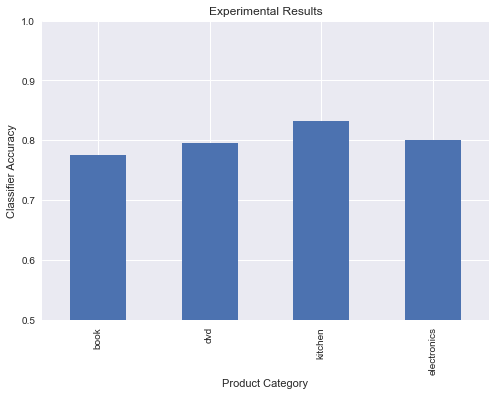

In [9]:
from classification_utils import *

prod_cats = ["book","dvd","kitchen","electronics"]
baseline = {}
for prod_cat in prod_cats:
    repetitions = 2 # accuracy figures are averaged over this many repetitions
    NB_accuracy_tot = 0
    for i in range(repetitions): # for each sample_size we will find average accuracy over several repetitions
        test, train   = get_formatted_train_test_data(prod_cat)
        NB_accuracy_tot += run_NB_preformatted(train,test)
    baseline[prod_cat] = NB_accuracy_tot/repetitions
    
pd.set_option('precision',2)
df = pd.DataFrame.from_dict(baseline,orient='index')
display(df)
ax = df.plot.bar(title="Experimental Results",legend=False)
ax.set_ylabel("Classifier Accuracy")
ax.set_xlabel("Product Category")
ax.set_ylim(0.5,1.0)

### Exercise
In the empty cell below, define the feature extractor function `FE_all`, which takes as input an `AmazonReview` object, and outputs a list of strings, where each string is a feature to be used by the Naïve Bayes classifier. 

Initially, define it to return all of the tokens in the review. We will adapt it in the exercises below.

In [2]:
from sussex_nltk.corpus_readers import AmazonReviewCorpusReader
def FE_all(review_object):
    return review_object.words()
arc = AmazonReviewCorpusReader()
FE_all(arc)

Sussex NLTK root directory is \\ad.susx.ac.uk\ITS\TeachingResources\Departments\Informatics\LanguageEngineering\resources


<generator object AmazonReviewCorpusReader.words at 0x000001F4ED102308>

In [3]:
# %load solutions/FE_all
def FE_all(review):
    return review.words()


### Exercise 
Now that you have defined a feature extractor function, you can pass it to the helper function `get_training_testing` that was used in the last exercise. 

Copy the code cell above that you used to produce the `baseline` dictionary, and adapt it to make use of your feature_extractor function, `FE_all`. 

Run the new code cell, and save the results in a new dictionary called `FE_all_results`. This feature extractor is have no impact on the features that the classifier is using so should not have a significant impact on the accuracy of the classifier.  Check that this is true.

In [ ]:
from classification_utils import *
prod_cats = ["book","dvd","kitchen","electronics"] 
FE_all_res = {} 
for prod_cat in prod_cats: 
    repetitions = 2 # accuracy figures are averaged over this many repetitions 
    NB_accuracy_tot = 0 
    for i in range(repetitions): # for each sample_size we will find average accuracy over several repetitions 
        test, train = get_formatted_train_test_data(prod_cat) 
        NB_accuracy_tot += run_NB_preformatted(train,test) 
    FE_all_res[prod_cat] = NB_accuracy_tot/repetitions   
pd.set_option('precision',2) 
df = pd.DataFrame.from_dict(FE_all_res,orient='index') 
display(df) 
ax = df.plot.bar(title="Experimental Results",legend=False) 
ax.set_ylabel("Classifier Accuracy") 
ax.set_xlabel("Product Category") 
ax.set_ylim(0.5,1.0)

,0
book,0.79
dvd,0.79
kitchen,0.82
electronics,0.80


(0.5, 1.0)

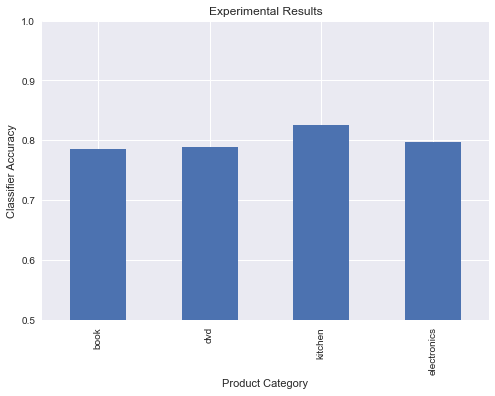

In [14]:
# %load solutions/test_FE_all
from classification_utils import *
prod_cats = ["book","dvd","kitchen","electronics"]
FE_all_results = {}
for prod_cat in prod_cats:
    repetitions = 2 # accuracy figures are averaged over this many repetitions
    NB_accuracy_tot = 0
    for i in range(repetitions): # for each sample_size we will find average accuracy over several repetitions
        test, train   = get_formatted_train_test_data(prod_cat,FE_all)
        NB_accuracy_tot += run_NB_preformatted(train,test)
    FE_all_results[prod_cat] = NB_accuracy_tot/repetitions    
pd.set_option('precision',2)
df = pd.DataFrame.from_dict(FE_all_results,orient='index')
display(df)
ax = df.plot.bar(title="Experimental Results",legend=False)
ax.set_ylabel("Classifier Accuracy")
ax.set_xlabel("Product Category")
ax.set_ylim(0.5,1.0)

### Exercise
In a new cell, define a feature extraction function that converts all tokens to lowercase. 
- Call your new feature extractor `FE_lower`.
- See the last section of the Topic 1 notebook for guidance on how to convert tokens to lowercase.

In [22]:
from sussex_nltk.corpus_readers import AmazonReviewCorpusReader
def FE_lower(review):
    return [word.lower() for word in review.words()]
arc = AmazonReviewCorpusReader()
FE_lower(arc)

['this',
 'book',
 'was',
 'horrible',
 '.',
 'if',
 'it',
 'was',
 'possible',
 'to',
 'rate',
 'it',
 'lower',
 'than',
 'one',
 'star',
 'i',
 'would',
 'have',
 '.',
 'i',
 'am',
 'an',
 'avid',
 'reader',
 'and',
 'picked',
 'this',
 'book',
 'up',
 'after',
 'my',
 'mom',
 'had',
 'gotten',
 'it',
 'from',
 'a',
 'friend',
 '.',
 'i',
 'read',
 'half',
 'of',
 'it',
 ',',
 'suffering',
 'from',
 'a',
 'headache',
 'the',
 'entire',
 'time',
 ',',
 'and',
 'then',
 'got',
 'to',
 'the',
 'part',
 'about',
 'the',
 'relationship',
 'the',
 '13',
 'year',
 'old',
 'boy',
 'had',
 'with',
 'a',
 '33',
 'year',
 'old',
 'man',
 'and',
 'i',
 'lit',
 'this',
 'book',
 'on',
 'fire',
 '.',
 'one',
 'less',
 'copy',
 'in',
 'the',
 'world',
 '...',
 'do',
 "n't",
 'waste',
 'your',
 'money',
 '.',
 'i',
 'wish',
 'i',
 'had',
 'the',
 'time',
 'spent',
 'reading',
 'this',
 'book',
 'back',
 'so',
 'i',
 'could',
 'use',
 'it',
 'for',
 'better',
 'purposes',
 '.',
 'this',
 'book',
 'wa

In [4]:
# %load solutions/FE_lower
def FE_lower(review):
    return [word.lower() for word in review.words()]


### Exercise
In a new cell, define a feature extraction function that converts all numbers to "NUM". 
- Call your new feature extractor `FE_NUM`.
- See the last section of the Topic 1 notebook for guidance on how to convert tokens to lowercase.

In [24]:
from sussex_nltk.corpus_readers import AmazonReviewCorpusReader
def FE_NUM(review):
    return ["NUM" if word.isdigit() else word for word in review.words()]
#arc = AmazonReviewCorpusReader()
#FE_NUM(arc)

In [5]:
# %load solutions/FE_NUM
def FE_NUM(review):
    return ["NUM" if word.isdigit() else word for word in review.words()]


### Exercise
In a new cell, define a feature extraction function that filters out non-alphabetic words and stopwords.
- Call your new feature extractor `FE_puncstop`.
- See the last section of the Topic 1 notebook for guidance on how to convert tokens to lowercase.
- Note that the following two lines must be placed in a cell where this feature extraction function is being used:  
`from nltk.corpus import stopwords`  
`stopwords = stopwords.words('english')`


In [29]:
from sussex_nltk.corpus_readers import AmazonReviewCorpusReader
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
def FE_puncstop(review):    
    return [word for word in review.words() if word not in stopwords and word.isalpha()]
#arc = AmazonReviewCorpusReader()
#FE_punctstop(arc)

In [6]:
# %load solutions/FE_puncstop
def FE_puncstop(review):
    return [word for word in review.words() if word.isalpha() and word not in stopwords]


### Exercise
In a new cell, define a feature extraction function that stems all of the tokens.
- Call your new feature extractor `FE_stem`.
- The code snippet below shows you how to set up a stemmer.

In [26]:
from nltk.stem.porter import PorterStemmer
from sussex_nltk.corpus_readers import AmazonReviewCorpusReader
stemmer = PorterStemmer() #Create a new stemmer
stemmed = stemmer.stem("complications") #Example usage, stemming a single word
def FE_stem(review):
    return [stemmer.stem(word) for word in review.words()] 


In [7]:
# %load solutions/FE_stem
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer() #Create a new stemmer

def FE_stem(review):
    return [stemmer.stem(word) for word in review.words()]


### Exercise
Now that you have defined several feature extraction functions, it is time to look at their impact on performance.

Make a copy of the cell that you used to determine the accuracy of your first feature extractor, and position the copied cell below this one.

Extend the code in the cell to do the following:
- Create a dictionary for each of your feature extraction functions.
- Display the results in a table using a Pandas dataframe. This table should have one row for each product category and one column for the product category names and additional columns for each of the five feature extraction function.

In [20]:
from classification_utils import *
def get_results(feature_extractor):
    results = {}
    for prod_cat in prod_cats:
        repetitions = 1 # accuracy figures are averaged over this many repetitions
        NB_accuracy_tot = 0
        for i in range(repetitions): # for each sample_size we will find average accuracy over several repetitions
            test, train   = get_formatted_train_test_data(prod_cat,feature_extractor)
            NB_accuracy_tot += run_NB_preformatted(train,test)
        results[prod_cat] = NB_accuracy_tot/repetitions
    return results

prod_cats = ["book","dvd","kitchen","electronics"]
FE_all_res = get_results(FE_all)
FE_lower_res= get_results(FE_lower)
FE_NUM_res = get_results(FE_NUM)
FE_puncstop_res = get_results(FE_puncstop)
FE_stem_res = get_results(FE_stem)

headers = ["cat","all","lower", "NUM", "puncstop", "stem"]
pd.set_option('precision',2) 
df = pd.DataFrame(list(zip(prod_cats,
                           [FE_all_res[prod_cat] for prod_cat in prod_cats],
                           [FE_lower_res[prod_cat] for prod_cat in prod_cats],
                           [FE_NUM_res[prod_cat] for prod_cat in prod_cats],
                           [FE_puncstop_res[prod_cat] for prod_cat in prod_cats],
                           [FE_stem_res[prod_cat] for prod_cat in prod_cats])),
                  columns=headers)
display(df)
ax = df.plot.bar(x=0,title="Experimental Results")
ax.set_ylabel("Classifier Accuracy")
ax.set_xlabel("Product Category")
ax.set_ylim(0.5,1.0)
ax.legend(bbox_to_anchor=(0.95, 1))

NameError: name 'FE_stem' is not defined

,cat,all,lower,NUM,puncstop,stem
0,book,0.78,0.78,0.78,0.79,0.78
1,dvd,0.79,0.79,0.80,0.81,0.78
2,kitchen,0.83,0.83,0.83,0.81,0.82
3,electronics,0.80,0.80,0.80,0.80,0.81


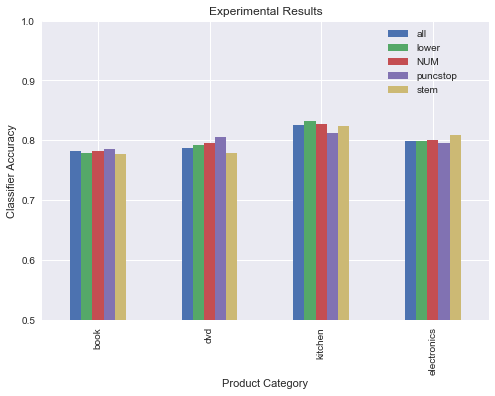

In [10]:
# %load solutions/test_FS
# %load ../Solutions/3/test_FS

def get_results(feature_extractor):
    results = {}
    for prod_cat in prod_cats:
        repetitions = 10 # accuracy figures are averaged over this many repetitions
        NB_accuracy_tot = 0
        for i in range(repetitions): # for each sample_size we will find average accuracy over several repetitions
            test, train = get_formatted_train_test_data(prod_cat,feature_extractor)
            NB_accuracy_tot += run_NB_preformatted(train,test)
        results[prod_cat] = NB_accuracy_tot/repetitions
    return results

prod_cats = ["book","dvd","kitchen","electronics"]
FE_all_results = get_results(FE_all)
FE_lower_results = get_results(FE_lower)
FE_NUM_results = get_results(FE_NUM)
FE_puncstop_results = get_results(FE_puncstop)
FE_stem_results = get_results(FE_stem)

headers = ["cat","all","lower", "NUM", "puncstop", "stem"]

pd.set_option('precision',2)

df = pd.DataFrame(list(zip(prod_cats,
                           [FE_all_results[prod_cat] for prod_cat in prod_cats],
                           [FE_lower_results[prod_cat] for prod_cat in prod_cats],
                           [FE_NUM_results[prod_cat] for prod_cat in prod_cats],
                           [FE_puncstop_results[prod_cat] for prod_cat in prod_cats],
                           [FE_stem_results[prod_cat] for prod_cat in prod_cats])),
                  columns=headers)
display(df)
ax = df.plot.bar(x=0,title="Experimental Results")
ax.set_ylabel("Classifier Accuracy")
ax.set_xlabel("Product Category")
ax.set_ylim(0.5,1.0)
ax.legend(bbox_to_anchor=(0.95, 1))